In [84]:
# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunjaedu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yunjaedu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yunjaedu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yunjaedu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     |████████████████████████████████| 12.0 MB 4.0 MB/s eta 0:00:01


In [11]:
trainv = pd.read_csv('data/train.csv')
testv = pd.read_csv('data/test.csv')

In [12]:
trainv.shape

(7613, 5)

In [13]:
testv.shape

(3263, 4)

## Display

In [14]:
display(trainv.sample(5))
display(testv.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


## Preprocess

In [15]:
def remove_URL(text):
    url = re.compile(r'httls?://\S+|www\.S+')
    return url.sub(r'',text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html,'',text)


def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [16]:
trainv['text_clean'] = trainv['text'].apply(lambda x : remove_URL(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x : remove_emoji(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x : remove_html(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x : remove_punct(x))

In [17]:
# Tokenize
trainv['tokenized'] = trainv['text_clean'].apply(word_tokenize)

In [18]:
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [19]:
trainv['lower'] = trainv['tokenized'].apply(lambda x : [word.lower() for word in x])

In [20]:
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala..."


In [21]:
# Remove stopwords
trainv['stopwords_removed'] = trainv['lower'].apply(lambda x : [word for word in x if word not in stop])

In [22]:
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [23]:
# apply part of speech tags.

trainv['pos_tags'] = trainv['stopwords_removed'].apply(nltk.tag.pos_tag)

In [24]:
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [25]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yunjaedu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
# Convert part of speechs to wordnet format.
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

trainv['wordnet_pos'] = trainv['pos_tags'].apply(lambda x : [(word,get_wordnet_pos(pos_tag)) for (word, pos_tag) in x ])

In [27]:
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


In [28]:
wnl = WordNetLemmatizer()

trainv['lemmatized'] = trainv['wordnet_pos'].apply(lambda x : [wnl.lemmatize(word,tag) for word, tag in x]) # recognize word with tag by extracting stem!

In [29]:
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi..."


In [30]:
trainv['lemmatized'] = trainv['lemmatized'].apply(lambda x : [word for word in x if word not in stop])

In [31]:
trainv['lemma_str'] = [' '.join(map(str,l)) for l in trainv['lemmatized']]

In [32]:
trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


## Visualize Data

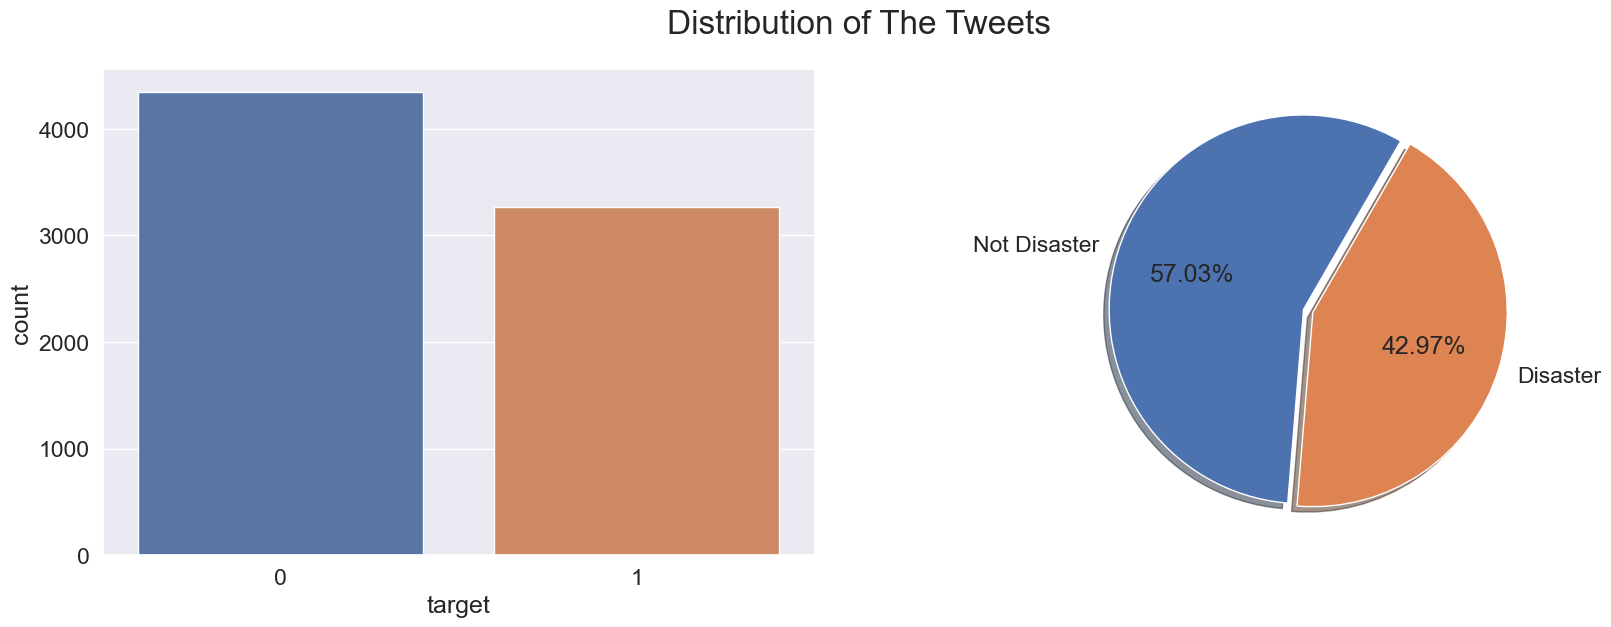

In [33]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (18,6), dpi = 100)
sns.countplot(trainv['target'], ax = axes[0])
axes[1].pie(trainv['target'].value_counts() , 
labels = ['Not Disaster', 'Disaster'],
autopct = '%1.2f%%',
shadow = True,
explode = (0.05,0),
startangle = 60)


fig.suptitle('Distribution of The Tweets',fontsize= 24)
plt.show()

In [34]:
# Tweet Lenghth

from sympy import construct_domain


trainv['Character Count'] = trainv['text_clean'].apply(lambda x : len(str(x)))

def plot_dist3(df, feature, title):
    # Create
    fig = plt.figure(constrained_layout = True, figsize = (18,8))

    grid = gridspec.GridSpec(ncols = 3, nrows = 3,figure = fig)

    ax1 = fig.add_subplot(grid[0,:2])

    ax1.set_title('Histogram')
    sns.distplot(df.loc[:,feature],
    hist = True,
    kde = True,
    ax =ax1,
    color = '#e74c3c')
    ax1.set(ylabel = 'Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins = 20))

    # Customize
    ax2 = fig.add_subplot(grid[1,:2])

    ax2.set_title('Empirical CDF')
    sns.distplot(df.loc[:, feature],
    ax =ax2,
    kde_kws= {'cumulative' : True},
    hist_kws = {'cumulative' : True},
    color = '#e74c3c')

    ax2.xaxis.set_major_locator(MaxNLocator(nbins = 20))

    ax2.set(ylabel = 'Cumulative Probability')



    ax3 = fig.add_subplot(grid[:,2])
    ax3.set_title('Box Plot')
    sns.boxplot(x = feature, data =df, orient = 'v', ax= ax3, color = '#e74c3c') # orient error
    ax3.yaxis.set_major_locator(MaxNLocator(nbins = 25))

    plt.suptitle(f'{title}',fontsize = 24)
    

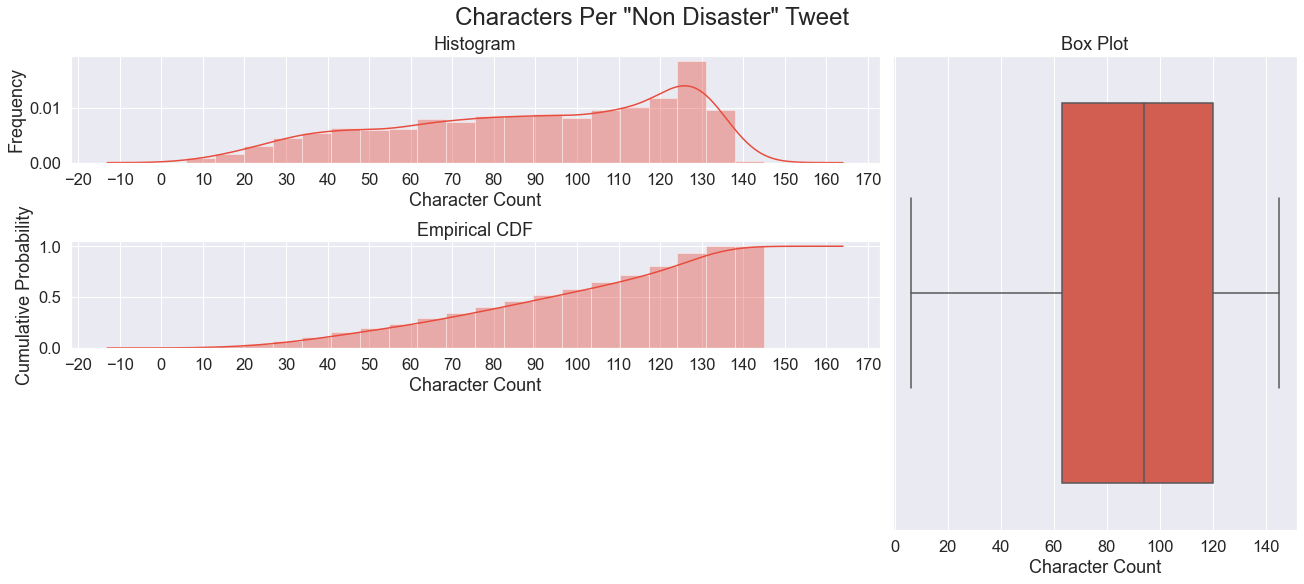

In [35]:
plot_dist3(trainv[trainv['target'] == 0], 'Character Count', 'Characters Per "Non Disaster" Tweet')

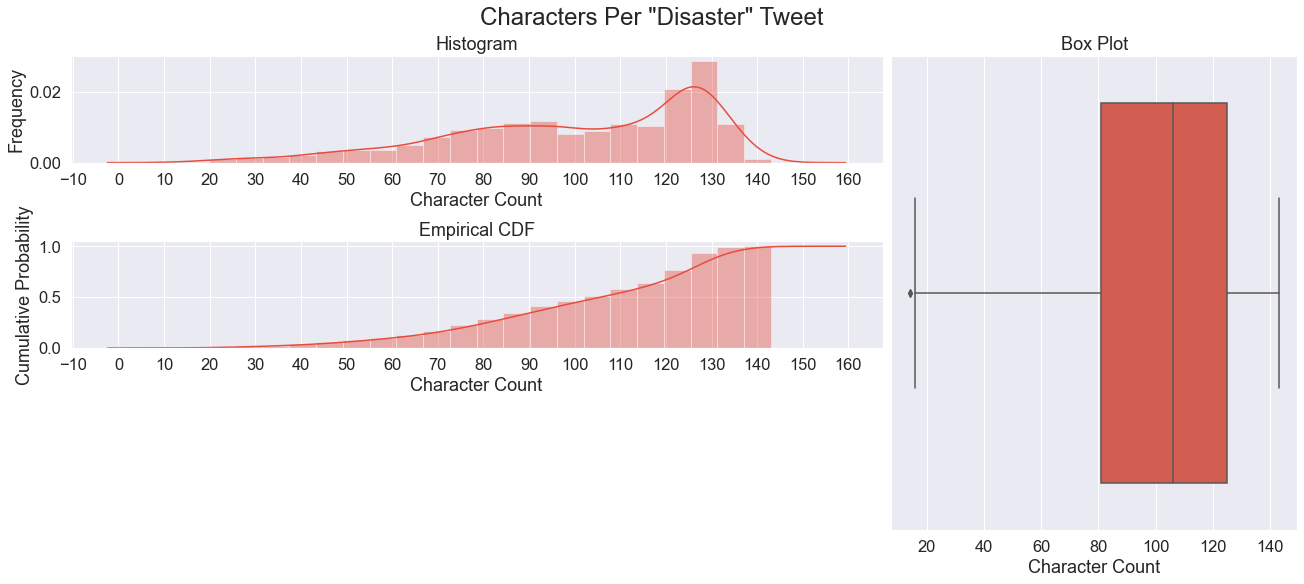

In [36]:
plot_dist3(trainv[trainv['target'] == 1], 'Character Count', 'Characters Per "Disaster" Tweet')

## Word Counts

In [37]:
def plot_word_number_histogram(textno, textye):
    fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize  = (18,6), sharey = True)
    sns.distplot(textno.str.split().map(lambda x : len(x)),ax= axes[0], color = '#e74c3c')
    sns.distplot(textye.str.split().map(lambda x : len(x)), ax = axes[1], color = '#e74c3c')

    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')

    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Words Per Tweet', fontsize = 24, va = 'baseline')

    fig.tight_layout()

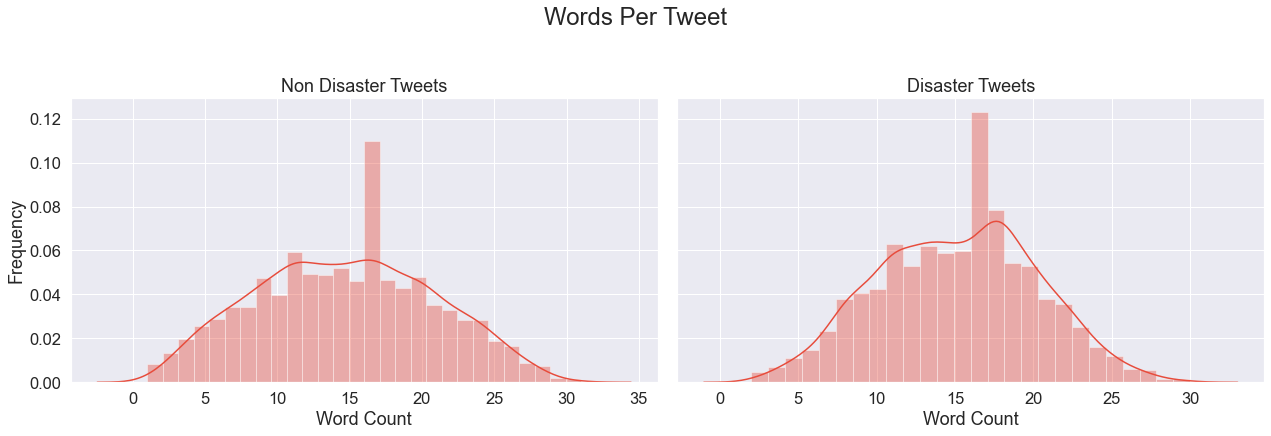

In [38]:
plot_word_number_histogram(trainv[trainv['target'] == 0]['text'],trainv[trainv['target'] == 1]['text'])

## Word Lengths

In [39]:
def plot_word_len_histogram(textno,textye):

    fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (18,6), sharey = True)

    sns.distplot(textno.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x)), ax = axes[0], color = '#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x : np.mean(x)), ax = axes[1], color = '#e74c3c')


    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')

    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Mean Word Lengths', fontsize = 24, va = 'baseline')
    fig.tight_layout()

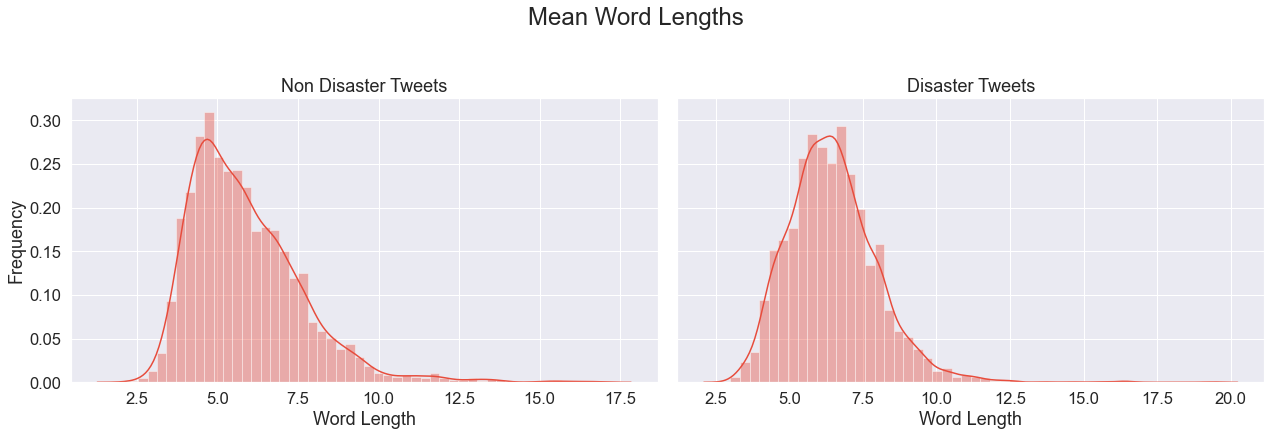

In [40]:
plot_word_len_histogram(trainv[trainv['target'] == 0]['text'], trainv[trainv['target'] == 1]['text'])

In [41]:
lis = [trainv[trainv['target'] ==0]['lemma_str'], trainv[trainv['target']==1]['lemma_str']]

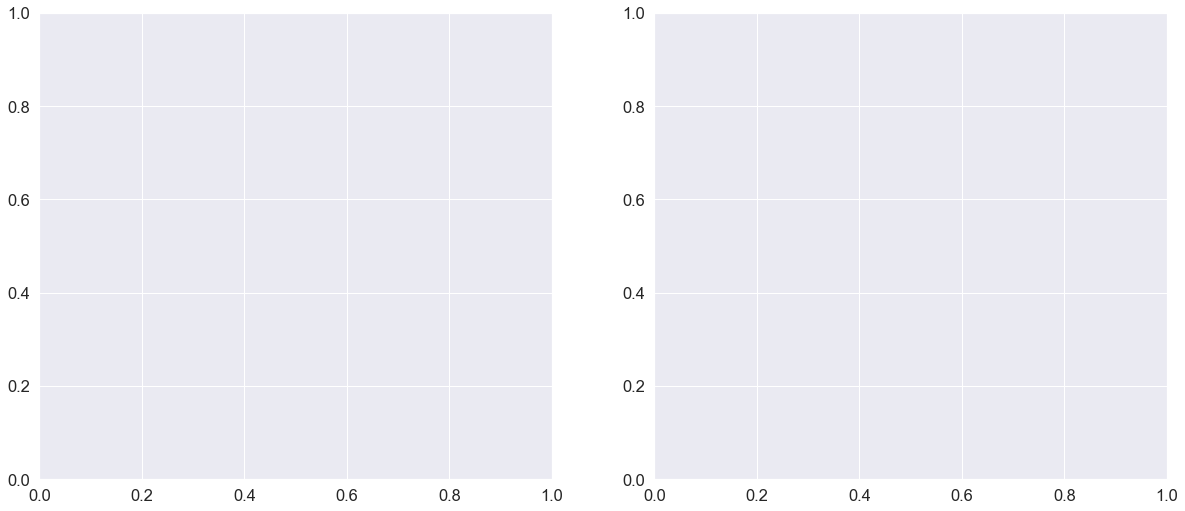

In [42]:
fig, axes = plt.subplots(1,2,figsize = (18,8))
axes = axes.flatten()

In [43]:
for i, j in zip(lis,axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        # print(f"new : {new}")
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        
        top = sorted(dic.items(), key = lambda x : x[1], reverse = True)[:15]
        x, y = zip(*top)
        df = pd.DataFrame([x,y]).T
        df = df.renaem(columns ={0 : 'Stopword', 1:'Count'})
        sns.barplot(x = 'Count', y= 'Stopwords', data = df, palette='plasma', ax = j)
        plt.tight_layout()

    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


## Most Common Words

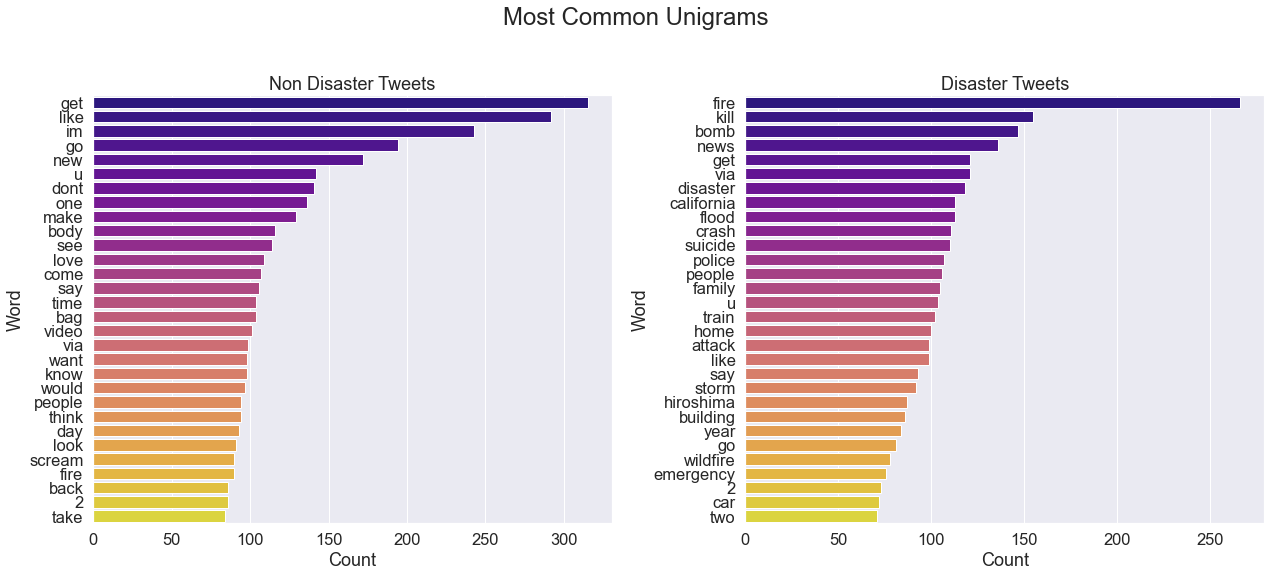

In [44]:
fig, axes = plt.subplots(1,2, figsize = (18,8))
axes = axes.flatten()

for i, j in zip(lis,axes):
    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()

    x, y= [], []

    for word, count in most[:30]:
        if (word not in stop):
            x.append(word),
            y.append(count)

    sns.barplot(x= y, y = x, palette= 'plasma', ax = j)

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')


fig.suptitle('Most Common Unigrams', fontsize = 24, va = 'baseline')
plt.tight_layout()

In [45]:
def ngrams(n, title):
    fig, axes = plt.subplots(1,2, figsize = (18,8))
    axes = axes.flatten()

    for i, j in zip(lis,axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in new]
        print(corpus[0])

        def _get_top_ngram(corpus, n = None):
            vec = CountVectorizer(ngram_range = (n,n), max_df = 0.9, stop_words= 'english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis = 0)
            words_freq = [(word, sum_words[0,idx]) for word, idx  in vec.vocabulary_.items()]

            words_freq = sorted(words_freq, key = lambda x : x[1], reverse = True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x= y, y= x, palette= 'plasma', ax = j)

        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')

        fig.suptitle(title, fontsize = 24, va = 'baseline')
        plt.tight_layout()

In [46]:
lis[1]

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident ask shelter place notify officer evac...
3       13000 people receive wildfire evacuation order...
4       get sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant crane hold bridge collapse nearby ho...
7609    ariaahrary thetawniest control wild fire calif...
7610    m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7611    police investigate ebike collide car little po...
7612    late home raze northern california wildfire ab...
Name: lemma_str, Length: 3271, dtype: object

['whats', 'man']
['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']


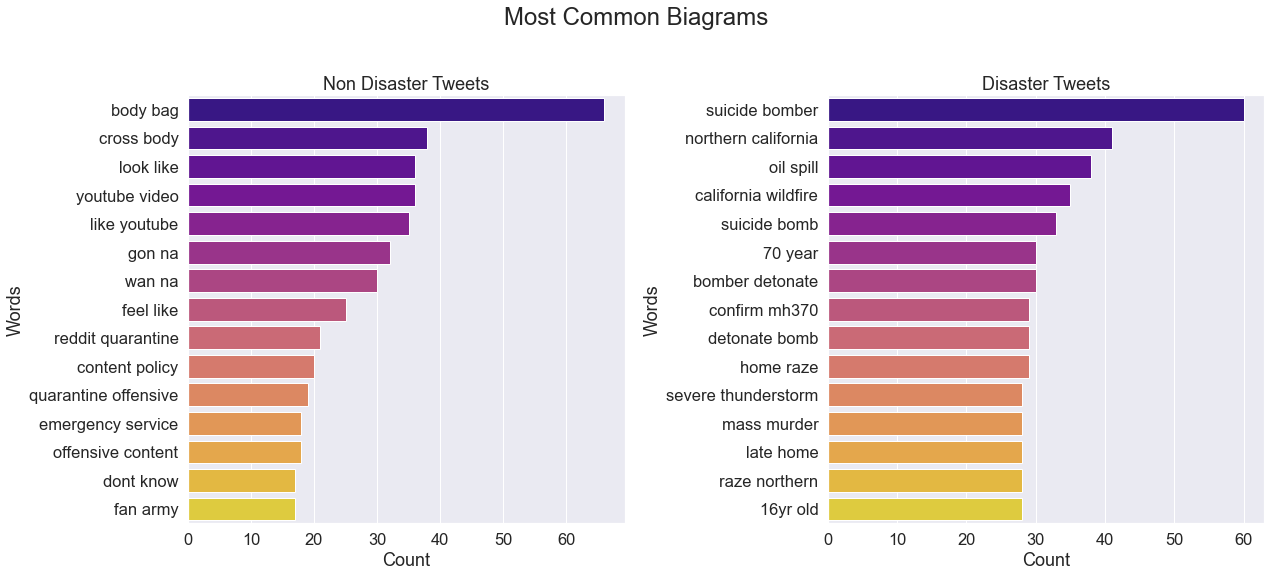

In [47]:
ngrams(2,'Most Common Biagrams')

['whats', 'man']
['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']


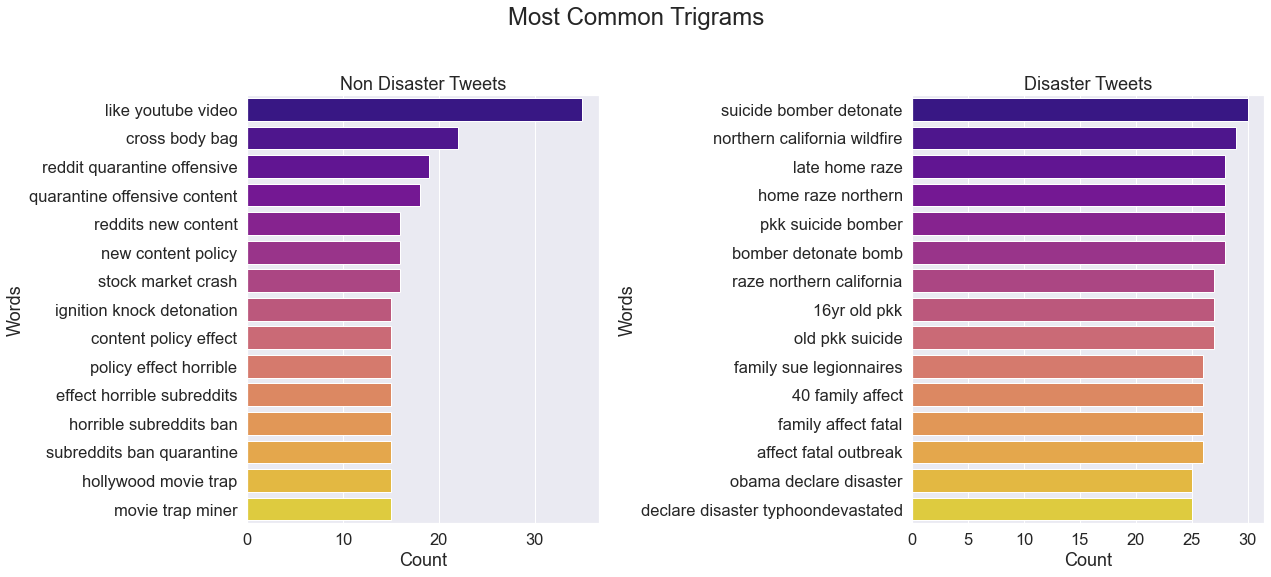

In [48]:
ngrams(3,'Most Common Trigrams')

## Determining Topics

NMF : https://jhryu1208.github.io/data/2020/12/10/ML_NMF/ <br>
https://bcho.tistory.com/1216

In [65]:
def display_topics(text, no_top_words, topic):
    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 25, max_features = 5000, use_idf = True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    #print(tfidf_feature_names)
    doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns = list(tfidf_feature_names))
    nmf = NMF(n_components= 10, random_state= 0, alpha = .1, init = 'nndsvd').fit(tfidf)
    print(topic)
    print(nmf.components_.shape)
    for topic_idx,topic in enumerate(nmf.components_):
        print(f"Topic {topic_idx + 1}")
        print(' '.join([tfidf_feature_names[i] for i in topic.argsort()[:-no_top_words -1 : -1]]))
        

In [66]:
display_topics(lis[0],10,"Non Disaster Topics\n")

Non Disaster Topics

(10, 252)
Topic 1
get blow lol good bomb first day demolish someone play
Topic 2
like video youtube look feel back fire fatality sink mudslide
Topic 3
im traumatise still disaster na gon attack drown dead weapon
Topic 4
new emergency full read post content quarantine storm many re
Topic 5
body bag cross shoulder woman full lady read ebay really
Topic 6
dont one see know come say make want think fire
Topic 7
scream fuck phone face good song loud hit baby time
Topic 8
via youtube god change obliteration news story stop service video
Topic 9
go quarantine content many explode reddit make let top deluge
Topic 10
love crush collide woman much death military armageddon would check


In [56]:
display_topics(lis[1], 10, 'Disaster Topics\n')

Disaster Topics

Topic 1
fire forest building truck wild evacuate burn california service set
Topic 2
suicide bomb kill bomber saudi mosque detonate pkk old 16yr
Topic 3
california wildfire home northern late news raze abc burn earthquake
Topic 4
flood crash train kill people derail news two cause accident
Topic 5
hiroshima atomic year bomb japan still anniversary 70 war bombing
Topic 6
via attack wave israeli police evacuation post heat wound car
Topic 7
mh370 family confirm malaysia wreckage pm debris conclusively investigator find
Topic 8
disaster nuclear obama natural declare saipan typhoondevastated sign northern collapse
Topic 9
storm violent video land wind severe thunderstorm go im area
Topic 10
get watch minute sandstorm swallow airport im go like dont


In [69]:
# Loading NER
nlp = en_core_web_sm.load()

OSError: [E053] Could not read config file from /Users/yunjaedu/opt/anaconda3/lib/python3.9/site-packages/en_core_web_sm/en_core_web_sm-2.3.1/config.cfg

In [68]:
!pip install nltk

!pip install spacy==2.3.5

!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz

!pip install pyresparser

     |████████████████████████████████| 10.1 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 992 kB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 8.3 MB/s eta 0:00:01
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.4
    Uninstalling srsly-2.4.4:
      Successfully uninstalled srsly-2.4.4
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.0
    Uninstalling thinc-8.1.0:
      Successfully uninstalled thinc-8.1.0
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.1
    Uninstalling spacy-3.4.1:
      Successfully uninstalled spacy-3.4.1
     |████████████████████████████████| 12.0 MB 17.9 MB/s eta 0:00:01   |▏                               | 81 kB 5.2 MB/s eta 0:00:03
  Created wheel for en-core-web-sm: filename=en_core_

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')


    print('There are %d Gpu(s) avaiable' % torch.cuda.device_count())

    print('we will use the GPU:',torch.cuda.get_device_name(0))
else:
    print('No Gpu avaiable, using the Cpu instead')
    device = torch.device('cpu')

No Gpu avaiable, using the Cpu instead


In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
labels = train['target'].values
idx = len(labels)

In [9]:
combined = pd.concat([train, test])
display(combined)
combined = combined.text.values

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


In [10]:
# Lowercase!!
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [86]:
print(f'Original : {combined[0]}')
print(f'tokenized : {tokenizer.tokenize(combined[0])}') # lowercase automathically
print(f'token IDS : {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0]))}')

Original : Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
tokenized : ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
token IDS : [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [87]:
max_len = 0


# Find Max len & Add speical tokens

for text in combined:
     input_ids = tokenizer.encode(text, add_special_tokens=True)
     max_len = max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [91]:
# Make list of sentence lengths


token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

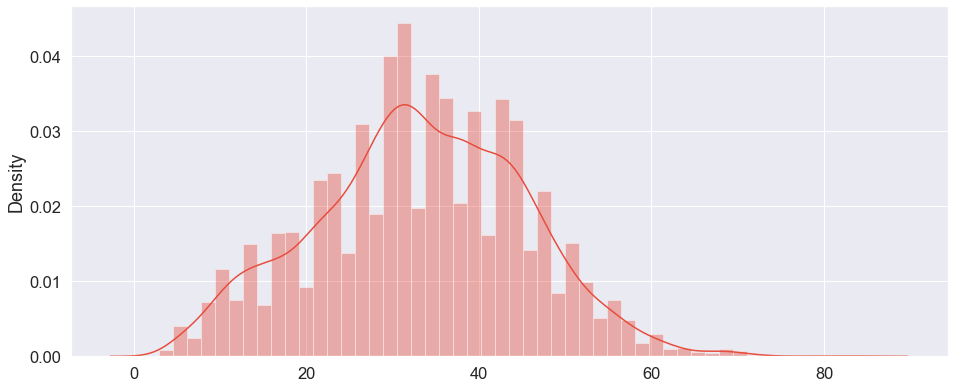

In [92]:
# Displaying sentence length dist.

fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

In [93]:
train= combined[:idx]
test = combined[idx:]
train.shape

(7613,)

In [94]:
test.shape

(3263,)

In [95]:
def tokenize_map(sentence,labs = 'None'):

    global labels
    input_ids = []
    attention_mask = []

    for text in sentence:
        #   "encode_plus" will:
        
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.

        encoded_dict = tokenizer.encode_plus(
            text, # Sentence to encode
            add_special_tokens = True, # Add ClS and SEP
            truncation = 'longest_first', # Activate and control truncation
            max_length = 84, # Max length according to out text data
            pad_to_max_length = True, # Pad & Truncate all sentence
            return_attention_mask = True, # Construct attn mask
            return_tensors = 'pt' # return pytorch tensors

        )

        input_ids.append(encoded_dict['input_ids'])

        attention_mask.append(encoded_dict['attention_mask'])

    # 텐서 변환
    input_ids = torch.cat(input_ids,dim = 0)
    attention_masks = torch.cat(attention_mask, dim = 0)

    if labs != 'None':
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks


In [98]:
input_ids, attention_masks, labels = tokenize_map(train,labels)

In [99]:
input_ids.shape

torch.Size([7613, 84])

In [100]:
print(1234)

1234


In [97]:
test_input_ids, test_attention_masks = tokenize_map(test)

In [62]:
print(f'trian input_ids : {input_ids} \n attentions_masks : {attention_masks} \n labels : {labels}')

trian input_ids : tensor([[  101,  2256, 15616,  ...,     0,     0,     0],
        [  101,  3224,  2543,  ...,     0,     0,     0],
        [  101,  2035,  3901,  ...,     0,     0,     0],
        ...,
        [  101, 23290,  1012,  ...,     0,     0,     0],
        [  101,  2610, 11538,  ...,     0,     0,     0],
        [  101,  1996,  6745,  ...,     0,     0,     0]]) 
 attentions_masks : tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]) 
 labels : tensor([1, 1, 1,  ..., 1, 1, 1])


In [63]:
# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

In [65]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [67]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [68]:
print(f'train size : {train_size}')
print(f'val size : {val_size}')

train size : 6090
val size : 1523


#### The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [70]:
batch_size = 32

# trian : order matter
train_dataloader = DataLoader(train_dataset,
sampler = RandomSampler(train_dataset), # select batch randomly
batch_size = batch_size)

# val : order doesn't matter
validation_dataloader = DataLoader(val_dataset,
sampler = SequentialSampler(val_dataset),
batch_size = batch_size) # Select batches randomly 


In [71]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data,sampler = prediction_sampler,batch_size = batch_size)


In [73]:
model = BertForSequenceClassification.from_pretrained('bert-large-uncased',
# Use 124-layer, 1024-hidden, 16-heads, 340M paramerters BERT model with an uncased vocab
num_labels = 2, # set the number of labels
output_attentions = False, # whether the model returns attentions weights
output_hidden_states = False) # whether the model returns all hidden-states)



Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [75]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [76]:
params = list(model.named_parameters())

print(f'The Bert Model has {len(params)} different named parameters')

print('== Embedding layer ===== \n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The Bert Model has 393 different named parameters
== Embedding layer ===== 

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (10

In [77]:
optimizer = AdamW(model.parameters(),
lr = 6e-6,
eps = 1e-8)

In [78]:
epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,
num_training_steps= total_steps)

In [79]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [80]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [83]:
# This training code is based on the `run_glue.py` script here:

# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.

training_stats = []

# Measure the total training time for the whole run.

total_t0 = time.time()

# For each epoch...

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:
    
    t0 = time.time()

    # Reset the total loss for this epoch.
    
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    
    # `dropout` and `batchnorm` layers behave differently during training vs. test ,
    # source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    
    model.train()

    # For each batch of training data...
    
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is 'convenient while training RNNs'. 
        # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is down here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
        
        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)
        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end, 
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        
        loss.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        
        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)
        
        optimizer.step()

        # Update the learning rate.
        
        scheduler.step()

    # Calculate the average loss over all of the batches.
    
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    
    model.eval()

    # Tracking variables:
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.
    
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is down here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.
            
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        
        total_eval_loss += loss.values
        
        # Move logits and labels to CPU:
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    
    # Report the final f1 score for this validation run.
    
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    # Measure how long the validation run took:
    
    validation_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


KeyboardInterrupt: 